In [74]:
from StrategyHandler import *
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from Production import Production
from functools import reduce

In [75]:
strategy=Strategy('btcusdt')
con = sqlite3.connect('market.db', timeout=10)

In [76]:
# p=Production()
# p.strategy.get_data(8000, 'btcusdt_1day_candle', 'btcusdt_60min_candle', 'btcusdt_30min_candle','btcusdt_15min_candle', 'btcusdt_5min_candle', 'btcusdt_1min_candle')
# freq=['1min','5min','15min','30min','60min','1day']
# period=[5,10,20,30,60]
# for x in freq:
#     for y in period:
#         p.boll_reverse_system(x,y)

In [77]:
p=Production()
p.strategy.get_data(8000, 'btcusdt_1day_candle', 'btcusdt_60min_candle', 'btcusdt_30min_candle','btcusdt_15min_candle', 'btcusdt_5min_candle', 'btcusdt_1min_candle')
p.ma_system("1day", 10, 20)
p.ma_system("60min", 10, 20)
p.boll_system("60min",30)
p.boll_system("1day",30)
p.boll_reverse_system("5min",30)
p.boll_reverse_system("15min",30)
portfolio=p.get_portfolio()

updated strategy:ma_system_1day_1020 at20:56:01
updated strategy:ma_system_60min_1020 at20:56:03
updated strategy:boll_system_60min_30 at20:56:04
updated strategy:boll_system_1day_30 at20:56:06
updated strategy:boll_reverse_system_5min_30 at20:56:11
updated strategy:boll_reverse_system_15min_30 at20:56:14


In [78]:
# p.strategy_list['ma_system_1day_1020'][0]['pnl'].cumsum().plot()

In [79]:
p.evaluate_strategy()

ma_system_1day_1020 Est Fee:0.136
ma_system_1day_1020 Total Return:3.29
ma_system_1day_1020 Sharp Ratio:4.71
ma_system_60min_1020 Est Fee:0.264
ma_system_60min_1020 Total Return:0.92
ma_system_60min_1020 Sharp Ratio:3.61
boll_system_60min_30 Est Fee:0.12
boll_system_60min_30 Total Return:1.08
boll_system_60min_30 Sharp Ratio:3.17
boll_system_1day_30 Est Fee:0.09
boll_system_1day_30 Total Return:3.99
boll_system_1day_30 Sharp Ratio:4.48
boll_reverse_system_5min_30 Est Fee:0.234
boll_reverse_system_5min_30 Total Return:0.62
boll_reverse_system_5min_30 Sharp Ratio:3.21
boll_reverse_system_15min_30 Est Fee:0.13
boll_reverse_system_15min_30 Total Return:0.39
boll_reverse_system_15min_30 Sharp Ratio:2.1


In [80]:
def get_performance(portfolio):
    trade=pd.read_sql('select * from btcusdt_trade_log', con)
    trade['direction']=((trade['OrderType'].str[0]=='b')*2-1)
    trade['position']=(trade['direction']*trade['Amount'].astype(float)).cumsum()
    trade['liability']=-(trade['Amount'].astype(float)*trade['Price'].astype(float)*trade['direction']).cumsum()
    portfolio=portfolio.reset_index()
    portfolio['id']*=1000
    portfolio.rename(columns={ portfolio.columns[0]: "Time" }, inplace = True)
    result=portfolio.merge(trade[['Time','position','Fee','liability']], how='outer', on='Time')
    performance=result.sort_values('Time')
    performance[['price','position_x','position_y','liability']]=performance[['price','position_x','position_y','liability']].fillna(method='ffill')
    performance=performance.fillna(0)
    performance['asset']=performance['position_y']*performance['price']
    performance['equity']=performance['asset']+performance['liability']
    performance['Fee']=performance['Fee'].astype(float).cumsum()*2
    performance['Time']=pd.to_datetime(performance['Time']/1000,unit='s')+pd.Timedelta('08:00:00')
    return performance

Est Fee:0.062
Total Return:0.08
Sharp Ratio:2.74


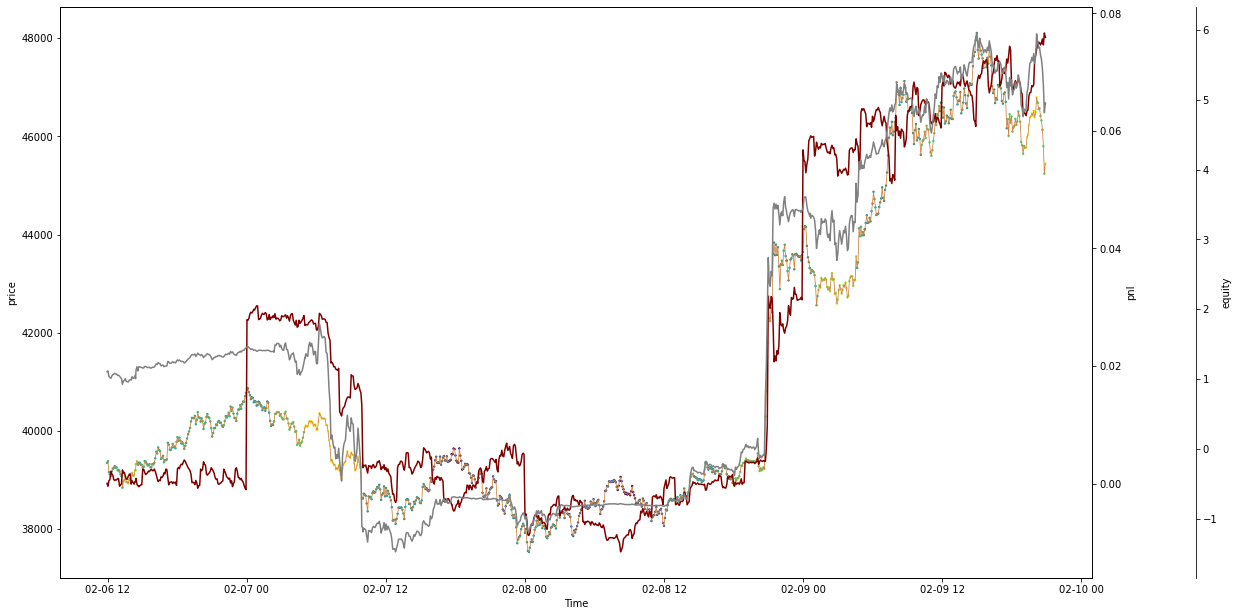

In [81]:
def plot_result(data):
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18.5, 10.5, forward=True)

    ax1.set_xlabel('Time')
    ax1.set_ylabel('price')
    ax1.plot(data['Time'], data['price'],color='peru',linewidth=0.8)
    ax1.scatter(data['Time'],data['price'],c=data['position_x'],s=2)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('position')
    ax2.set_ylabel('pnl')
    ax2.plot(data['Time'],data['pnl'].cumsum(),color='maroon') 
    
    ax3= ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.1))
    ax3.set_ylabel('equity')
    ax3.plot(data['Time'],data['equity'],color='grey')
#     ax3.plot(data['Time'],data['Fee'])

    number_trades=sum(data['position_x'].diff()!=0)
    print("Est Fee:" + str(number_trades*0.002))
    print("Total Return:"+ str(round(data['pnl'].sum(),2)))
    print("Sharp Ratio:"+ str(round(data['pnl'].sum()/data['pnl'].cumsum().std(),2)))

x=get_performance(portfolio)
plot_result(x.tail(1000))

In [82]:
x.tail(50)

,Time,position_x,pnl,price,position_y,Fee,liability,asset,equity
9981,2021-02-09 17:10:00.000000000,0.166667,0.000909,46721.05,0.000404,2.734786,-13.461908,18.861395,5.399486
9982,2021-02-09 17:15:00.000000000,0.166667,0.001644,46668.58,0.000404,2.734786,-13.461908,18.840212,5.378304
9983,2021-02-09 17:20:00.000000000,0.166667,-0.000702,46865.23,0.000404,2.734786,-13.461908,18.919600,5.457692
9984,2021-02-09 17:25:00.000000000,0.166667,-0.000105,46894.69,0.000404,2.734786,-13.461908,18.931494,5.469585
9985,2021-02-09 17:30:00.000000000,0.166667,0.000541,46705.41,0.000404,2.734786,-13.461908,18.855081,5.393172
9986,2021-02-09 17:35:00.000000000,0.166667,0.001924,46166.33,0.000404,2.734786,-13.461908,18.637453,5.175545
9987,2021-02-09 17:40:00.000000000,0.500000,-0.000670,46351.82,0.000404,2.734786,-13.461908,18.712336,5.250427
10190,2021-02-09 17:40:24.131999969,0.500000,0.000000,46351.82,0.000696,2.734787,-27.016997,32.265951,5.248954
9988,2021-02-09 17:45:00.000000000,0.500000,0.001253,46012.01,0.000696,2.734787,-27.016997,32.029406,5.012409
9989,2021-02-09 17:50:00.000000000,0.500000,0.001600,46453.68,0.000696,2.734787,-27.016997,32.336857,5.319859
